In [ ]:
# Install Ultralytics Library
# This cell installs the YOLOv8 library and its dependencies.
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00


In [ ]:
# Verify Ultralytics Installation and System Environment
# This cell imports ultralytics and torch, then runs a check to ensure proper installation
# and displays CUDA (GPU) availability and version information.
import ultralytics
import torch

# Verify installation and check environment
ultralytics.checks()

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Setup complete ✅ (12 CPUs, 167.1 GB RAM, 38.1/235.7 GB disk)
Torch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# Mount Google Drive
# This cell mounts Google Drive to access datasets and save model outputs persistently.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy Dataset from Google Drive to Local Colab Storage
# This cell defines source and destination directories, then copies the dataset
# from Google Drive to a local directory in Colab for faster access during processing.
import os
import shutil

# Define the source directory on Google Drive
INPUT_DIR_DRIVE = '/content/drive/MyDrive/malaria_quantitation/full_dataset'

# Define the local destination directory in Colab
INPUT_DIR_LOCAL = '/content/local_malaria_data'

# Clear the local destination directory if it exists
if os.path.exists(INPUT_DIR_LOCAL):
    shutil.rmtree(INPUT_DIR_LOCAL)
    print(f"Cleared existing local directory: {INPUT_DIR_LOCAL}")

# Create the local destination directory if it doesn't exist
os.makedirs(INPUT_DIR_LOCAL, exist_ok=True)
print(f"Created local directory: {INPUT_DIR_LOCAL}")

# Copy all files and directories from Google Drive to local storage
# Using a shell command for recursive copy
!cp -r "{INPUT_DIR_DRIVE}"/* "{INPUT_DIR_LOCAL}"

print(f"Copied contents from '{INPUT_DIR_DRIVE}' to '{INPUT_DIR_LOCAL}'")
print(f"Files in local directory: {os.listdir(INPUT_DIR_LOCAL)[:5]}...")

Created local directory: /content/local_malaria_data
Copied contents from '/content/drive/MyDrive/malaria_quantitation/full_dataset' to '/content/local_malaria_data'
Files in local directory: ['plasmodium-0650.jpg', 'plasmodium-0279.xml', 'plasmodium-2630.jpg', 'plasmodium-1992.jpg', 'plasmodium-1999.jpg']...


In [ ]:
# Prepare Dataset for YOLOv8 Training
# This cell processes the raw dataset, converting XML annotations to YOLO format,
# splitting data into training and validation sets, and organizing them into
# the required directory structure for YOLOv8. It also generates a dataset.yaml file.
import os
import glob
import shutil
import random
import yaml
import xml.etree.ElementTree as ET
from PIL import Image

# Define directories
INPUT_DIR = '/content/local_malaria_data'
# Changed DEST_DIR to a dedicated dataset folder, separate from model outputs
DATASET_DIR = '/content/malaria_dataset'

IMAGES_TRAIN = os.path.join(DATASET_DIR, 'images/train')
IMAGES_VAL = os.path.join(DATASET_DIR, 'images/val')
LABELS_TRAIN = os.path.join(DATASET_DIR, 'labels/train')
LABELS_VAL = os.path.join(DATASET_DIR, 'labels/val')

# --- Clear and (re)create directories ---
# Only clear the dataset directory, preserving models in other folders
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)
    print(f"Cleared existing dataset directory: {DATASET_DIR}")

# Create main destination directory and its subdirectories
for d in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
    os.makedirs(d, exist_ok=True)
print(f"Recreated directories under: {DATASET_DIR}")

# Identify XML files
xml_files = glob.glob(os.path.join(INPUT_DIR, '*.xml'))
print(f"Found {len(xml_files)} XML files in {INPUT_DIR}")

# Explicitly define the class name as requested by the user
class_names = ['Trophozoite']
class_map = {'Trophozoite': 0}
print(f"Classes mapping: {class_map}")

# Split data
random.seed(42)
random.shuffle(xml_files)
split_idx = int(len(xml_files) * 0.8)
train_files = xml_files[:split_idx]
val_files = xml_files[split_idx:]

def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def process_dataset(files, img_dest, label_dest):
    count = 0
    for xml_file in files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Robust filename determination
            image_found = False
            img_filename = None
            img_path = None

            # Try getting filename from XML
            fname_node = root.find('filename')
            if fname_node is not None and fname_node.text:
                potential_path = os.path.join(INPUT_DIR, fname_node.text)
                if os.path.exists(potential_path):
                    img_path = potential_path
                    img_filename = fname_node.text
                    image_found = True

            # Fallback: check directory for matching basenames
            if not image_found:
                basename = os.path.splitext(os.path.basename(xml_file))[0]
                for ext in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
                    potential_path = os.path.join(INPUT_DIR, basename + ext)
                    if os.path.exists(potential_path):
                        img_path = potential_path
                        img_filename = basename + ext
                        image_found = True
                        break

            if not image_found:
                print(f"Image for {os.path.basename(xml_file)} not found. Skipping.")
                continue

            # Robust size determination
            w, h = 0, 0
            size_node = root.find('size')
            if size_node is not None:
                w_node = size_node.find('width')
                h_node = size_node.find('height')
                if w_node is not None and h_node is not None:
                    w = int(w_node.text)
                    h = int(h_node.text)

            # If size missing or invalid, read from image
            if w <= 0 or h <= 0:
                with Image.open(img_path) as img:
                    w, h = img.size

            # Copy image
            shutil.copy(img_path, os.path.join(img_dest, img_filename))

            # Create label file
            label_file = os.path.splitext(img_filename)[0] + '.txt'
            with open(os.path.join(label_dest, label_file), 'w') as f:
                for obj in root.iter('object'):
                    cls_name_node = obj.find('name')
                    # Assume all relevant objects should be classified as 'Trophozoite'
                    if cls_name_node is not None and cls_name_node.text:
                        cls_id = class_map['Trophozoite']
                        xmlbox = obj.find('bndbox')
                        if xmlbox is not None:
                            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                            bb = convert_to_yolo((w, h), b)
                            f.write(f"{cls_id} {bb[0]} {bb[1]} {bb[2]} {bb[3]}\n")
            count += 1
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
            continue

    return count

print("Processing training set...")
train_count = process_dataset(train_files, IMAGES_TRAIN, LABELS_TRAIN)
print("Processing validation set...")
val_count = process_dataset(val_files, IMAGES_VAL, LABELS_VAL)

# Create dataset.yaml
yaml_content = {
    'path': DATASET_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(class_names),
    'names': class_names
}

yaml_path = os.path.join(DATASET_DIR, 'dataset.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"\nDataset setup complete.")
print(f"Configuration saved to: {yaml_path}")
print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")

Recreated directories under: /content/malaria_dataset
Found 2703 XML files in /content/local_malaria_data
Classes mapping: {'Trophozoite': 0}
Processing training set...
Processing validation set...

Dataset setup complete.
Configuration saved to: /content/malaria_dataset/dataset.yaml
Training images: 2162
Validation images: 541


Visualizing ground truth for: plasmodium-1294.jpg


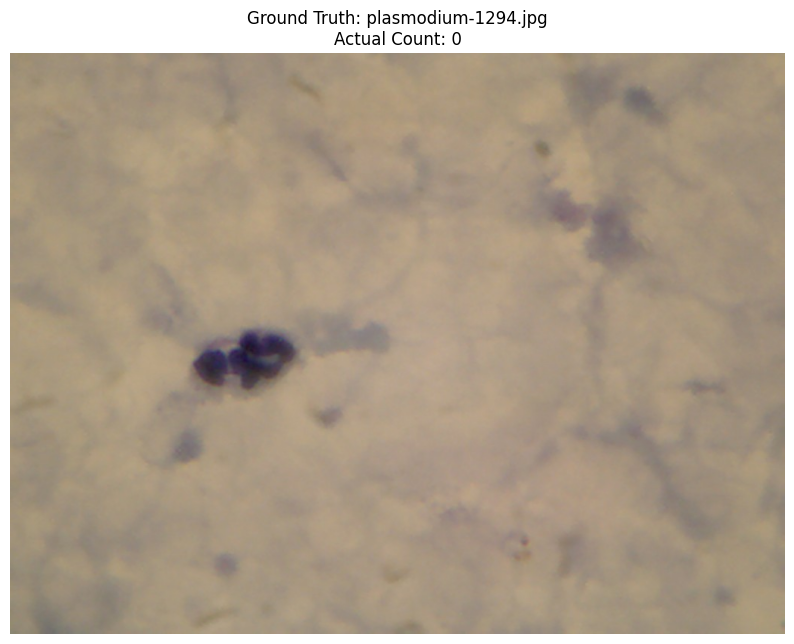

In [ ]:
# Visualize Ground Truth Annotations
# This cell randomly selects an image from the training set and visualizes
# its bounding box annotations to confirm correct data preparation.
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Select a random image from the training set to visualize its ground truth
train_images = glob.glob(os.path.join(IMAGES_TRAIN, '*.jpg')) # IMAGES_TRAIN is available from the data prep cell
if train_images:
    random_image_path = random.choice(train_images)
    print(f"Visualizing ground truth for: {os.path.basename(random_image_path)}")

    # Load the image
    img = cv2.imread(random_image_path)
    img_height, img_width, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the corresponding label file
    label_filename = os.path.splitext(os.path.basename(random_image_path))[0] + '.txt'
    label_path = os.path.join(LABELS_TRAIN, label_filename) # LABELS_TRAIN is available

    actual_count = 0
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            annotations = f.readlines()
        actual_count = len(annotations)

        for ann in annotations:
            parts = ann.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                # Convert normalized YOLO coordinates to pixel coordinates
                x1 = int((x_center - width / 2) * img_width)
                y1 = int((y_center - height / 2) * img_height)
                x2 = int((x_center + width / 2) * img_width)
                y2 = int((y_center + height / 2) * img_height)

                # Draw bounding box
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box

                # Put class label
                label = class_names[class_id] # class_names is available
                cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.title(f"Ground Truth: {os.path.basename(random_image_path)}\nActual Count: {actual_count}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No label file found for {os.path.basename(random_image_path)}")
else:
    print("No training images found to visualize.")

In [ ]:
# Train YOLOv8 Model
# This cell initializes a YOLOv8s model and trains it using the prepared dataset.
# The trained weights and logs are saved to Google Drive for persistence.
from ultralytics import YOLO
import os

# Define a persistent directory for models on Google Drive
# This ensures weights are saved even if the runtime disconnects
MODELS_DIR = '/content/drive/MyDrive/malaria_quantitation/malaria_models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Initialize the YOLOv8 Small model
model = YOLO('yolov8s.pt')

# Train the model with advanced augmentations and longer duration
results = model.train(
    data='/content/malaria_dataset/dataset.yaml', # Point to the separated dataset dir
    epochs=100,
    imgsz=1280,
    project=MODELS_DIR, # Save results to the persistent models directory on Drive
    name='yolov8s_malaria_final',
    mosaic=1.0,
    mixup=0.1,
    degrees=180,
    patience=15
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/malaria_dataset/dataset.yaml, degrees=180, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_malaria_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

In [ ]:
# Display Training Performance Metrics
# This cell prints key performance metrics (e.g., F1, Precision, Recall, mAP)
# obtained from the trained model's results.
import matplotlib.pyplot as plt

if 'results' in locals() and results is not None:
    print("--- Training Performance Metrics ---")
    # Removed results.epochs and results.best_epoch as DetMetrics object does not have these attributes
    print(f"Best F1: {results.results_dict.get('metrics/f1_score', 'N/A')}")
    print(f"Best Precision: {results.results_dict.get('metrics/precision(B)', 'N/A')}")
    print(f"Best Recall: {results.results_dict.get('metrics/recall(B)', 'N/A')}")
    print(f"Best mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A')}")
    print(f"Best mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A')}")
    print(f"Val Box Loss: {results.results_dict.get('val/box_loss', 'N/A')}")
    print(f"Val DFL Loss: {results.results_dict.get('val/dfl_loss', 'N/A')}")
    print(f"Val Class Loss: {results.results_dict.get('val/cls_loss', 'N/A')}")

--- Training Performance Metrics ---
Best F1: N/A
Best Precision: 0.8238782453666539
Best Recall: 0.8209617882345155
Best mAP50: 0.8364102133685728
Best mAP50-95: 0.3926261819901959
Val Box Loss: N/A
Val DFL Loss: N/A
Val Class Loss: N/A


Loaded training logs from: /content/drive/MyDrive/malaria_quantitation/malaria_models/yolov8s_malaria_final/results.csv


epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   41.1381         2.08034         2.21153         1.71078   
1      2   78.6885         1.87222         1.55694         1.53964   
2      3  115.6630         1.85772         1.46060         1.54018   
3      4  152.4480         1.83893         1.38502         1.52016   
4      5  189.8380         1.81294         1.29730         1.49933   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.39203            0.43150           0.31944   
1               0.65460            0.67681           0.58709   
2               0.72632            0.77461           0.72472   
3               0.70439            0.80279           0.72454   
4               0.60906            0.59697           0.54450   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.07343       2.32546       2.24806       1.86512  0.000662   
1              0.18286       2.13558       1.86650       1.73001  0.001315   
2              0.22481       2.17415       1.41999       1.59045  0.001956   
3              0.19491       2.27984       1.45740       1.76385  0.001941   
4              0.12390       2.54314       1.79982       1.90462  0.001921   

     lr/pg1    lr/pg2  
0  0.000662  0.000662  
1  0.001315  0.001315  
2  0.001956  0.001956  
3  0.001941  0.001941  
4  0.001921  0.001921

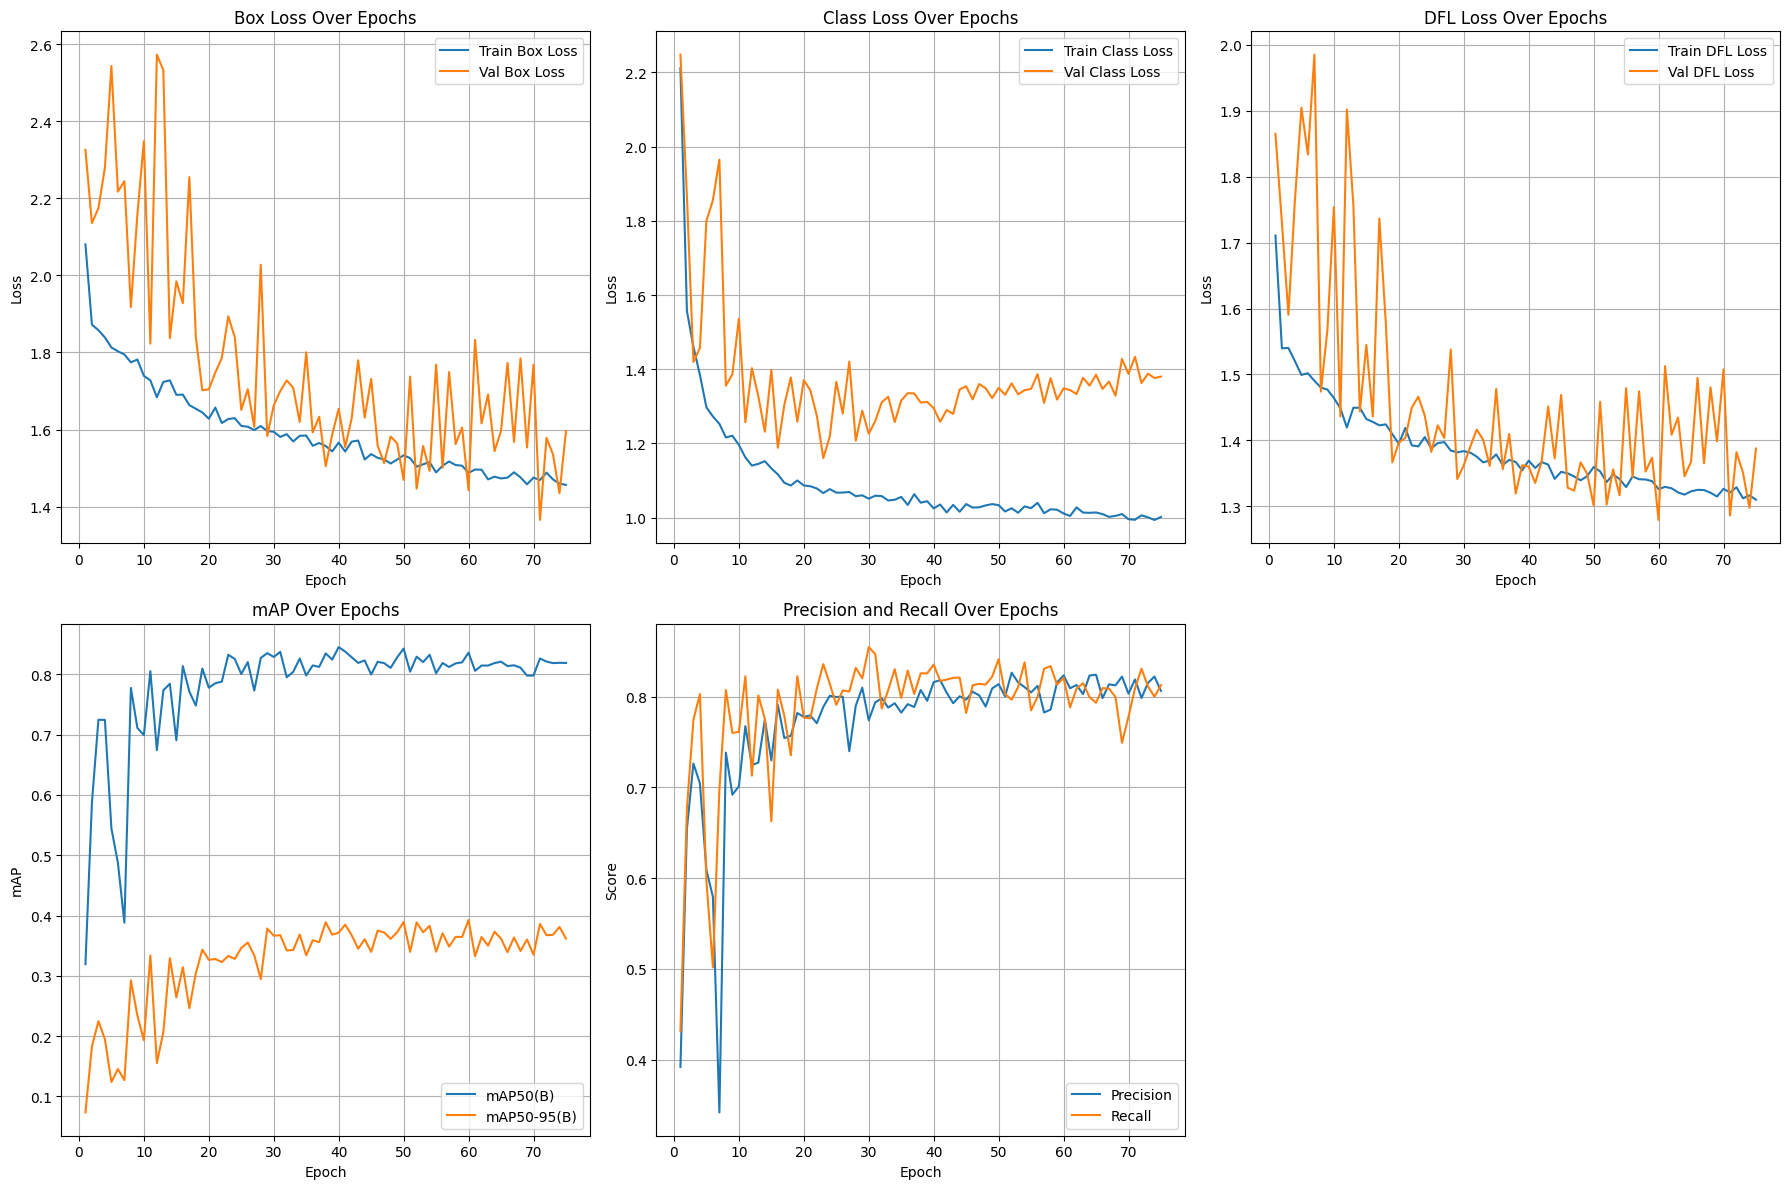

In [ ]:
# Plot Training Performance from Saved Logs
# This cell loads the 'results.csv' file from the training run and generates
# plots for various training and validation metrics over epochs (e.g., losses, mAP, precision, recall).
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the path to the saved results.csv file
# This path should correspond to the 'save_dir' printed during training
TRAINING_LOG_DIR = os.path.join(MODELS_DIR, 'yolov8s_malaria_final') # The name parameter 'yolov8s_malaria_refined' gets appended with a number by ultralytics if it's rerun
RESULTS_CSV_PATH = os.path.join(TRAINING_LOG_DIR, 'results.csv')

if os.path.exists(RESULTS_CSV_PATH):
    # Load the results CSV file
    # The header in ultralytics results.csv usually starts with '# Epoch' followed by a space
    # pandas read_csv needs to handle this space correctly for column names.
    df_results = pd.read_csv(RESULTS_CSV_PATH)
    df_results.columns = [col.strip() for col in df_results.columns]

    print(f"Loaded training logs from: {RESULTS_CSV_PATH}")
    display(df_results.head())

    # Plotting training metrics over epochs
    plt.figure(figsize=(18, 12))

    # Plot Box Loss
    plt.subplot(2, 3, 1) # 2 rows, 3 columns, 1st plot
    plt.plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss')
    plt.plot(df_results['epoch'], df_results['val/box_loss'], label='Val Box Loss')
    plt.title('Box Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Cls Loss
    plt.subplot(2, 3, 2) # 2 rows, 3 columns, 2nd plot
    plt.plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Class Loss')
    plt.plot(df_results['epoch'], df_results['val/cls_loss'], label='Val Class Loss')
    plt.title('Class Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot DFL Loss
    plt.subplot(2, 3, 3) # 2 rows, 3 columns, 3rd plot
    plt.plot(df_results['epoch'], df_results['train/dfl_loss'], label='Train DFL Loss')
    plt.plot(df_results['epoch'], df_results['val/dfl_loss'], label='Val DFL Loss')
    plt.title('DFL Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot mAP50 and mAP50-95
    plt.subplot(2, 3, 4) # 2 rows, 3 columns, 4th plot
    plt.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='mAP50(B)')
    plt.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='mAP50-95(B)')
    plt.title('mAP Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()
    plt.grid(True)

    # Plot Precision and Recall
    plt.subplot(2, 3, 5) # 2 rows, 3 columns, 5th plot
    plt.plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Precision')
    plt.plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Recall')
    plt.title('Precision and Recall Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print(f"Training results file not found at {RESULTS_CSV_PATH}. Please ensure training was successful and check the path.")

Found 541 validation images.

Parasite Counts per Image (Actual vs Predicted):


Image  Actual  Predicted  Difference
0    plasmodium-0650.jpg       0          1           1
1    plasmodium-0651.jpg       0          0           0
2    plasmodium-1680.jpg       2          2           0
3    plasmodium-1630.jpg       0          0           0
4    plasmodium-1094.jpg      12         11          -1
..                   ...     ...        ...         ...
536  plasmodium-1462.jpg      75         79           4
537  plasmodium-2593.jpg      77         81           4
538  plasmodium-2250.jpg       9         11           2
539  plasmodium-0715.jpg      73         80           7
540  plasmodium-1943.jpg      11         10          -1

[541 rows x 4 columns]


Sample Detections (Predicted boxes in Default, Ground Truth in Green):


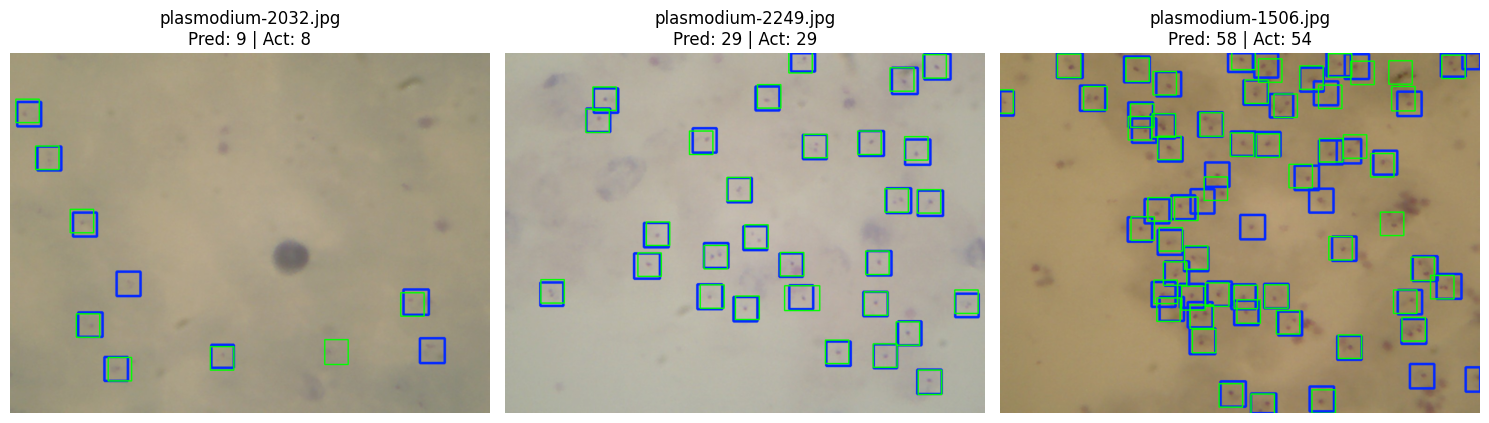

In [ ]:
# Perform Inference and Quantification on Validation Set
# This cell loads the best-trained YOLOv8 model, runs inference on the validation images,
# counts predicted parasites, compares them to actual counts, and displays the results.
# It also visualizes sample detections with both predicted and ground truth bounding boxes.
import glob
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
import random
from ultralytics import YOLO

# Define paths
INPUT_DIR_LOCAL = '/content/local_malaria_data'
DATASET_DIR = '/content/malaria_dataset'
# Update MODELS_DIR to the Google Drive path
MODELS_DIR = '/content/drive/MyDrive/malaria_quantitation/malaria_models'

# Path to the new refined model weights in the models directory
BEST_WEIGHTS = os.path.join(MODELS_DIR, 'yolov8s_malaria_refined/weights/best.pt')
VAL_IMAGES_DIR = os.path.join(DATASET_DIR, 'images/val')

# Load the trained model
model = YOLO(BEST_WEIGHTS)

# Get validation images
val_images = glob.glob(os.path.join(VAL_IMAGES_DIR, '*.jpg'))
print(f"Found {len(val_images)} validation images.")

# Run inference (Standard YOLO, no SAHI)
# Added batch=1 to process images one by one to prevent OutOfMemoryError
# Reducing imgsz for inference to prevent OutOfMemoryError
results = model.predict(val_images, conf=0.25, iou=0.5, verbose=False)

# Process results
counts = []
for result in results:
    path = result.path
    filename = os.path.basename(path)
    pred_count = len(result.boxes)

    # Get actual count
    xml_name = os.path.splitext(filename)[0] + '.xml'
    xml_path = os.path.join(INPUT_DIR_LOCAL, xml_name)
    actual_count = 0
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            actual_count = len(list(root.iter('object')))
        except:
            actual_count = -1
    else:
        actual_count = -1

    counts.append({
        'Image': filename,
        'Actual': actual_count,
        'Predicted': pred_count,
        'Difference': pred_count - actual_count
    })

# DataFrame
df_counts = pd.DataFrame(counts)
print("\nParasite Counts per Image (Actual vs Predicted):")
display(df_counts)

# Visualization
print("\nSample Detections (Predicted boxes in Default, Ground Truth in Green):")
plt.figure(figsize=(15, 5))
sample_results = random.sample(results, min(len(results), 3))

for i, result in enumerate(sample_results):
    # Plot predictions
    img_plot = result.plot(conf=False, labels=False)
    img_rgb = cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB)

    # Plot/Orig dimensions for scaling
    plot_h, plot_w = img_plot.shape[:2]
    orig_h, orig_w = result.orig_shape[:2]
    scale_x = plot_w / orig_w
    scale_y = plot_h / orig_h

    # Ground Truth
    filename = os.path.basename(result.path)
    xml_name = os.path.splitext(filename)[0] + '.xml'
    xml_path = os.path.join(INPUT_DIR_LOCAL, xml_name)

    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.iter('object'):
                xmlbox = obj.find('bndbox')
                if xmlbox is not None:
                    x1 = int(float(xmlbox.find('xmin').text) * scale_x)
                    y1 = int(float(xmlbox.find('ymin').text) * scale_y)
                    x2 = int(float(xmlbox.find('xmax').text) * scale_x)
                    y2 = int(float(xmlbox.find('ymax').text) * scale_y)
                    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        except Exception as e:
            print(f"Error drawing GT: {e}")

    # Title
    row = df_counts[df_counts['Image'] == filename].iloc[0]
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"{filename}\nPred: {row['Predicted']} | Act: {row['Actual']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Quantification Metrics
# This cell computes various metrics (MAE, RMSE, R2, MAPE, accuracy) to assess
# the model's performance in accurately counting parasites.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Extract actual and predicted counts
actual_counts = df_counts['Actual']
predicted_counts = df_counts['Predicted']

# --- Standard Regression Metrics ---
# 1. Mean Absolute Error (MAE): Average absolute difference
mae = mean_absolute_error(actual_counts, predicted_counts)

# 2. Root Mean Squared Error (RMSE): Penalizes larger errors more
mse = mean_squared_error(actual_counts, predicted_counts)
rmse = np.sqrt(mse)

# 3. R-squared (R2): How well the predictions fit the actual data (variance explained)
r2 = r2_score(actual_counts, predicted_counts)

# --- Counting Specific Metrics ---
# 4. Mean Absolute Percentage Error (MAPE) - Adjusted
# Only calculate MAPE for images where Actual > 0 to avoid division by zero (or epsilon skew)
mask = actual_counts > 0
if mask.sum() > 0:
    mape = np.mean(np.abs((actual_counts[mask] - predicted_counts[mask]) / actual_counts[mask])) * 100
else:
    mape = 0.0 # Handle case with no positive samples

# 5. Accuracy (Tolerance based)
# Exact Match
exact_match = np.mean(actual_counts == predicted_counts) * 100
# Within +/- 1
within_one = np.mean(np.abs(actual_counts - predicted_counts) <= 1) * 100
# Within +/- 5 (Good for high density)
within_five = np.mean(np.abs(actual_counts - predicted_counts) <= 5) * 100

# --- New Metric: Mean Difference ---
mean_difference = df_counts['Difference'].mean()

print("--- Quantification Performance Metrics ---")
print(f"Mean Absolute Error (MAE):       {mae:.2f}  (Lower is better)")
print(f"Root Mean Squared Error (RMSE):  {rmse:.2f}  (Lower is better)")
print(f"R-squared (R2) Score:            {r2:.2f}  (Higher is better, max 1.0)")
print(f"MAPE (on non-zero images):       {mape:.2f}% (Lower is better)")
print("-" * 40)
print(f"Mean Difference (Predicted - Actual): {mean_difference:.2f}  (Positive values suggest overprediction, negative values suggest underprediction)")
print("-" * 40)
print(f"Exact Match Accuracy:            {exact_match:.2f}%")
print(f"Accuracy (within +/- 1 count):   {within_one:.2f}%")
print(f"Accuracy (within +/- 5 counts):  {within_five:.2f}%")

--- Quantification Performance Metrics ---
Mean Absolute Error (MAE):       2.28  (Lower is better)
Root Mean Squared Error (RMSE):  4.48  (Lower is better)
R-squared (R2) Score:            0.95  (Higher is better, max 1.0)
MAPE (on non-zero images):       21.86% (Lower is better)
----------------------------------------
Mean Difference (Predicted - Actual): 0.11  (Positive values suggest overprediction, negative values suggest underprediction)
----------------------------------------
Exact Match Accuracy:            30.87%
Accuracy (within +/- 1 count):   56.38%
Accuracy (within +/- 5 counts):  89.28%


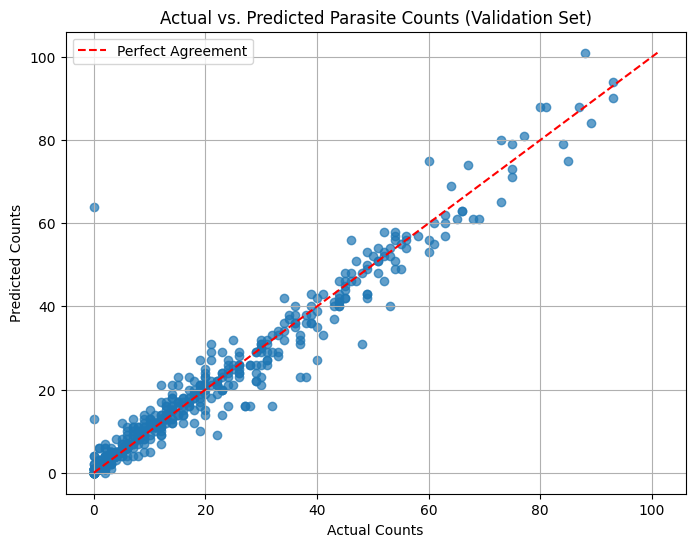

Scatter plot showing actual versus predicted parasite counts generated.


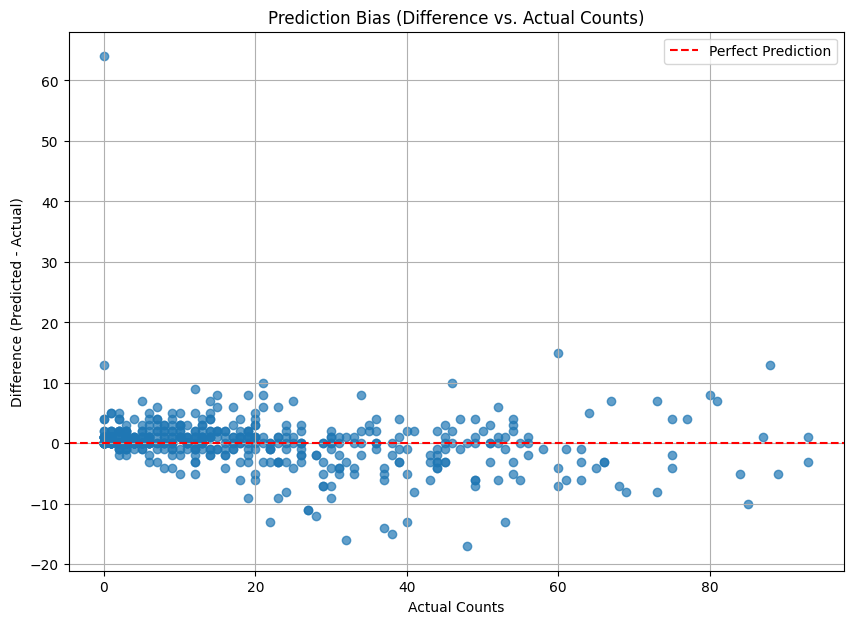

Scatter plot showing prediction bias generated.


In [ ]:
# Visualize Quantification Performance
# This cell generates scatter plots to visualize the relationship between actual
# and predicted parasite counts, and the prediction bias (difference vs. actual counts).
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot of actual vs. predicted counts
plt.figure(figsize=(8, 6))
plt.scatter(actual_counts, predicted_counts, alpha=0.7)

# Add a line of perfect agreement
max_count = max(actual_counts.max(), predicted_counts.max())
plt.plot([0, max_count], [0, max_count], 'r--', label='Perfect Agreement')

plt.title('Actual vs. Predicted Parasite Counts (Validation Set)')
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.grid(True)
plt.legend()
plt.show()

print("Scatter plot showing actual versus predicted parasite counts generated.")

# Create a scatter plot of Difference vs. Actual Counts
plt.figure(figsize=(10, 7))
plt.scatter(df_counts['Actual'], df_counts['Difference'], alpha=0.7)

# Add a horizontal line at y=0 for perfect prediction
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Prediction')

plt.title('Prediction Bias (Difference vs. Actual Counts)')
plt.xlabel('Actual Counts')
plt.ylabel('Difference (Predicted - Actual)')
plt.grid(True)
plt.legend()
plt.show()

print("Scatter plot showing prediction bias generated.")

In [ ]:
# Prepare External Validation Dataset
# This cell copies an external validation dataset from Google Drive to local
# Colab storage, organizing it into 'Uninfected' and 'Infected' categories.
import os
import shutil

# Define the source directory on Google Drive
VAL_SRC_DRIVE = '/content/drive/MyDrive/malaria_quantitation/Val_small_dataset'

# Define the local destination directory
VAL_DEST_LOCAL = '/content/external_val_data'

# Clean up existing local directory if it exists
if os.path.exists(VAL_DEST_LOCAL):
    shutil.rmtree(VAL_DEST_LOCAL)
    print(f"Cleared existing directory: {VAL_DEST_LOCAL}")

# Create the local directory
os.makedirs(VAL_DEST_LOCAL, exist_ok=True)
print(f"Created directory: {VAL_DEST_LOCAL}")

# Copy files from Drive to local storage
# This command will copy the 'Uninfected' and 'Infected' subfolders
# from VAL_SRC_DRIVE into VAL_DEST_LOCAL
!cp -r "{VAL_SRC_DRIVE}"/* "{VAL_DEST_LOCAL}"

# Verify the copy operation by listing contents of subdirectories
print("\nVerifying contents in Uninfected folder:")
uninfected_files = os.listdir(os.path.join(VAL_DEST_LOCAL, 'Uninfected')) if os.path.exists(os.path.join(VAL_DEST_LOCAL, 'Uninfected')) else []
print(f"Found {len(uninfected_files)} items in {os.path.join(VAL_DEST_LOCAL, 'Uninfected')}")
print(f"Sample files: {uninfected_files[:5]}")

print("\nVerifying contents in Infected folder:")
infected_files = os.listdir(os.path.join(VAL_DEST_LOCAL, 'Infected')) if os.path.exists(os.path.join(VAL_DEST_LOCAL, 'Infected')) else []
print(f"Found {len(infected_files)} items in {os.path.join(VAL_DEST_LOCAL, 'Infected')}")
print(f"Sample files: {infected_files[:5]}")

if not uninfected_files and not infected_files:
    print("Error: No files found in external validation subdirectories.")

Created directory: /content/external_val_data

Verifying contents in Uninfected folder:
Found 51 items in /content/external_val_data/Uninfected
Sample files: ['Image2207.jpg', 'Image2179.jpg', 'Image2175.jpg', 'Image2180.jpg', 'Image2171.jpg']

Verifying contents in Infected folder:
Found 50 items in /content/external_val_data/Infected
Sample files: ['Image06.jpg', 'Image38.jpg', 'Image40.jpg', 'Image11.jpg', 'Image09.jpg']


Loading Model for Live Demo...


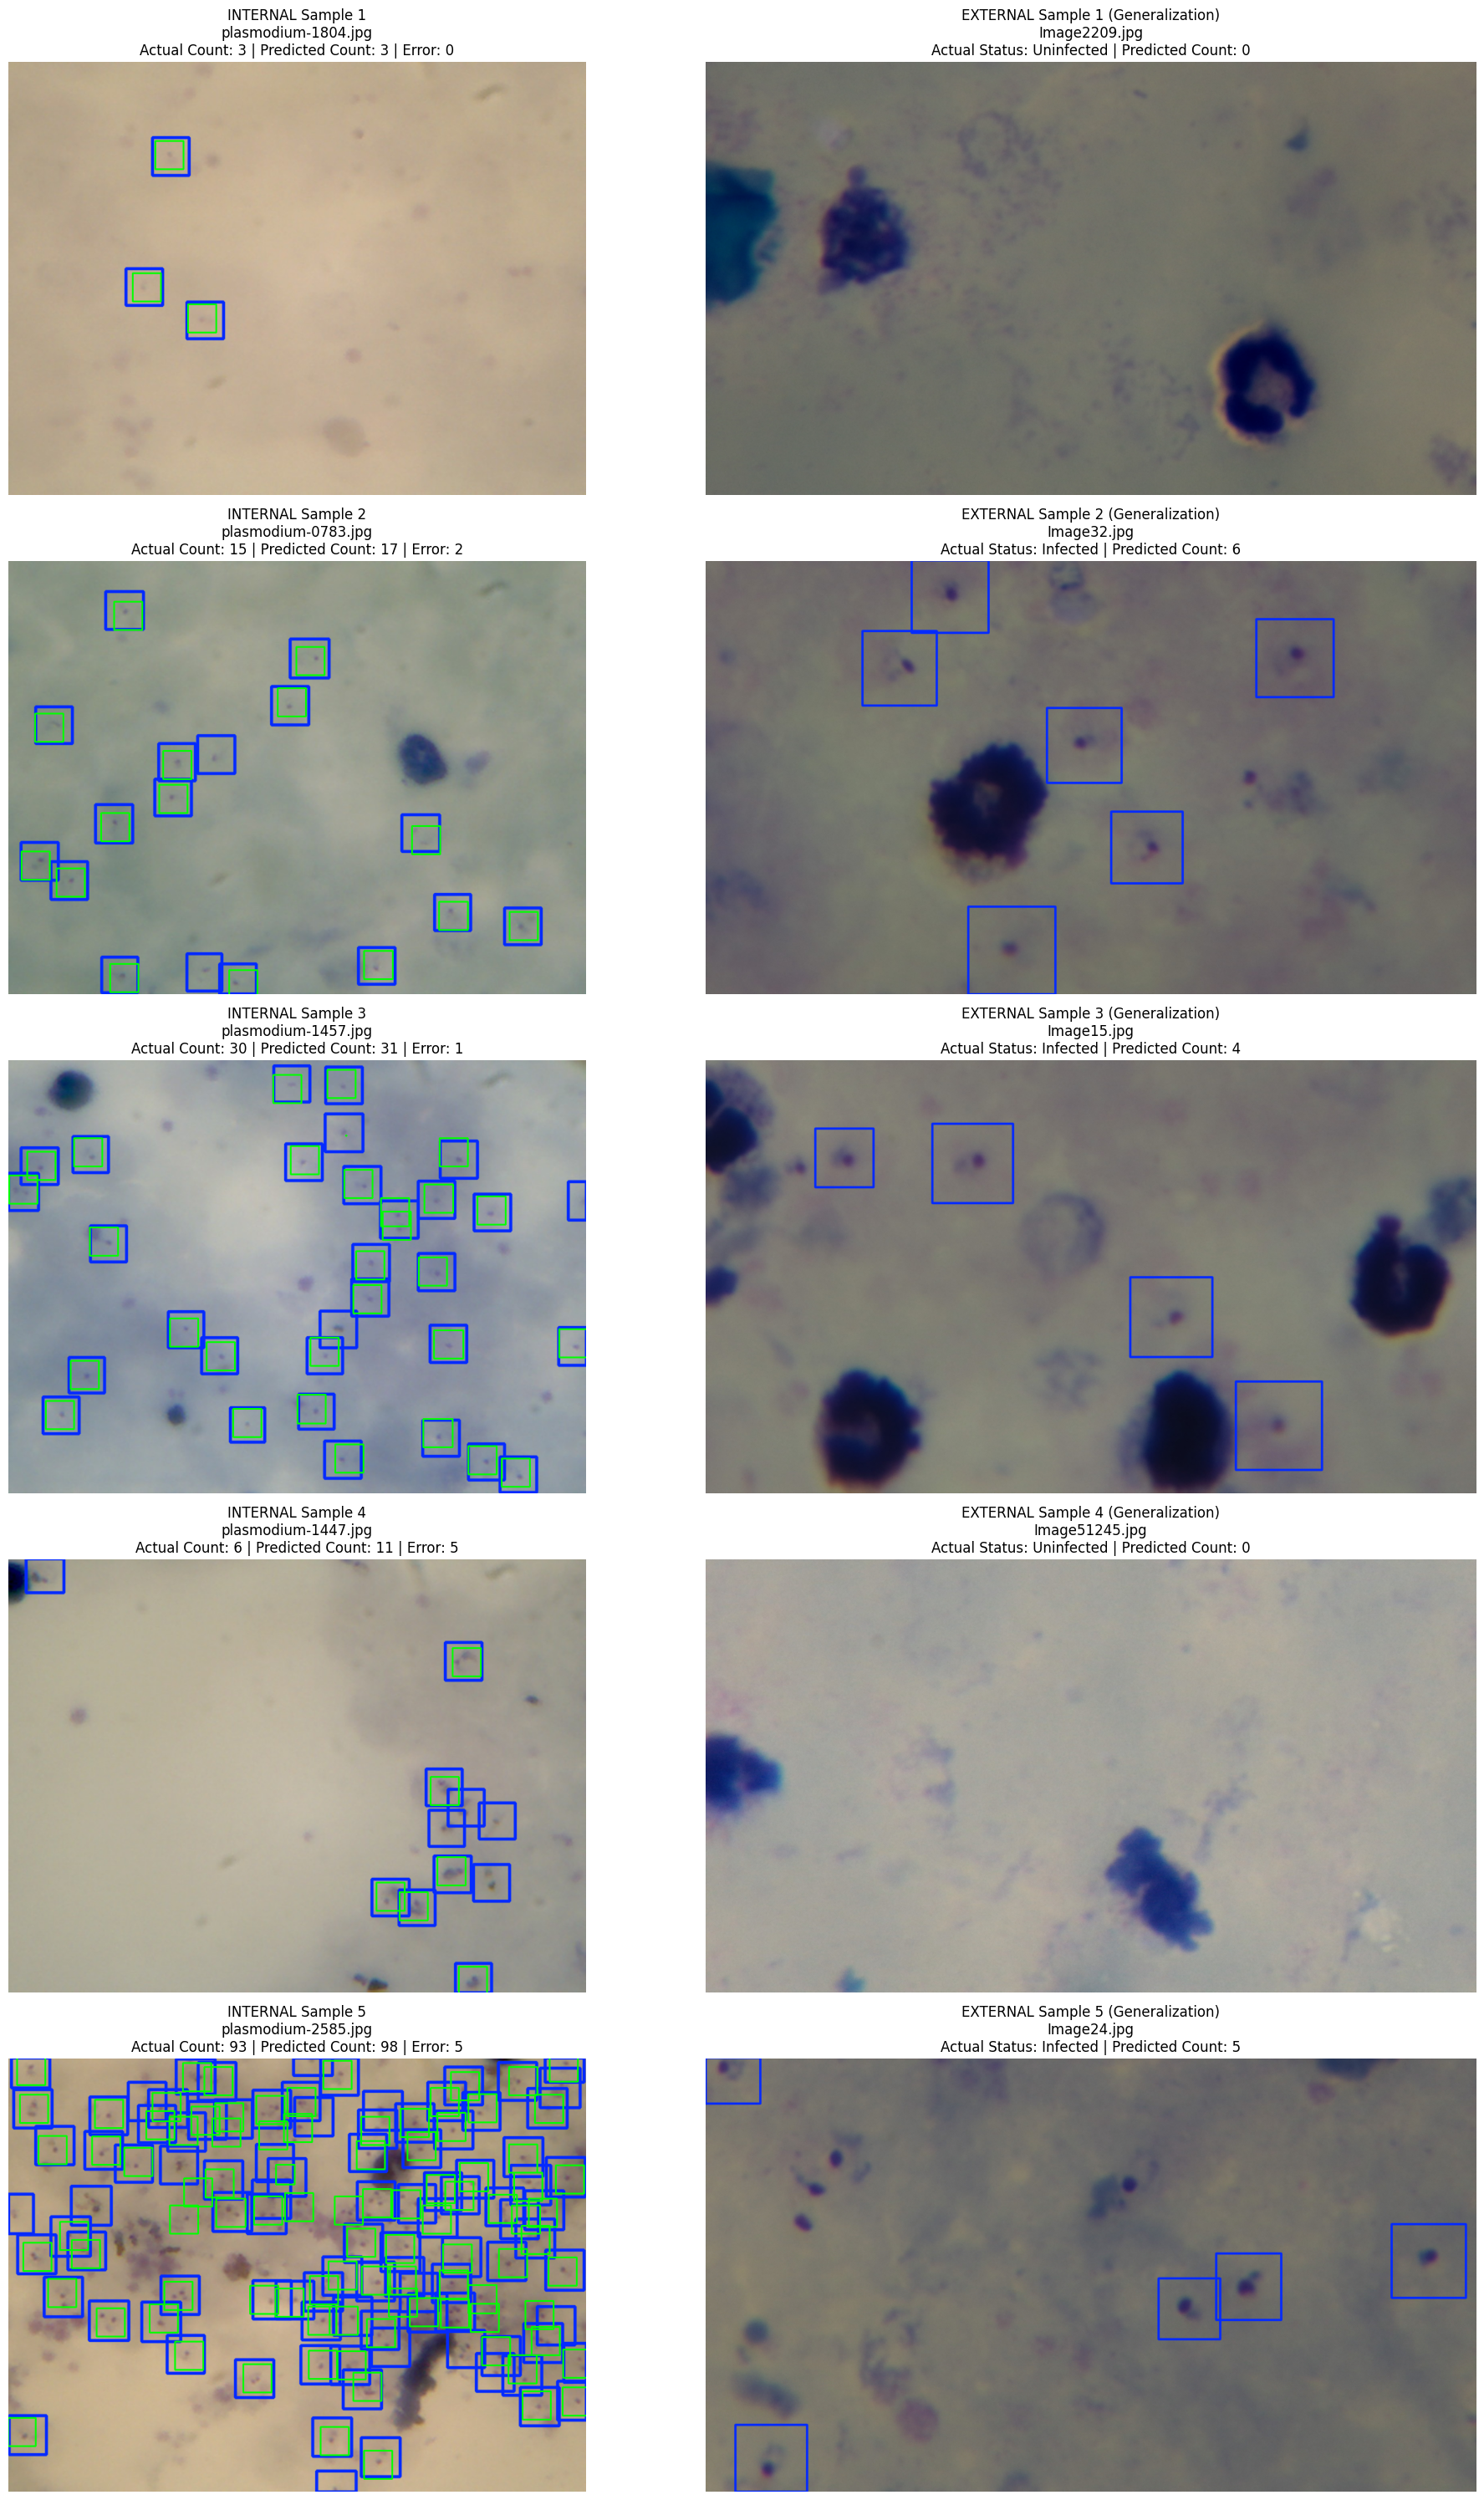

In [ ]:
# Live Demo: Internal vs. External Sample Detections
# This cell performs inference on a few random images from both the internal
# validation set (with ground truth) and the external validation set (for generalization).
# It visualizes predictions and ground truth (where available) side-by-side.
import random
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
import xml.etree.ElementTree as ET
import math
import glob

# --- Configuration ---
# Paths (from your previous cells)
INTERNAL_IMG_DIR = '/content/malaria_dataset/images/val'
INTERNAL_XML_DIR = '/content/local_malaria_data' # Original XMLs are here
EXTERNAL_IMG_DIR = '/content/external_val_data'
MODEL_PATH = '/content/drive/MyDrive/malaria_quantitation/malaria_models/yolov8s_malaria_refined/weights/best.pt'

# Load Model (cached if possible)
print("Loading Model for Live Demo...")
if os.path.exists(MODEL_PATH):
    model = YOLO(MODEL_PATH)
else:
    print(f"Error: Model not found at {MODEL_PATH}. Please ensure training is complete.")
    model = None

def get_random_internal_sample():
    images = glob.glob(os.path.join(INTERNAL_IMG_DIR, '*.jpg'))
    if not images:
        return None, None, None
    img_path = random.choice(images)
    filename = os.path.basename(img_path)
    xml_path = os.path.join(INTERNAL_XML_DIR, os.path.splitext(filename)[0] + '.xml')

    actual = -1
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            actual = len(list(tree.getroot().iter('object')))
        except: pass
    return img_path, actual, xml_path

def get_random_external_sample():
    uninfected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Uninfected')
    infected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Infected')

    all_ext_images = []
    if os.path.exists(uninfected_dir):
        all_ext_images.extend(glob.glob(os.path.join(uninfected_dir, '*.jpg')))
    if os.path.exists(infected_dir):
        all_ext_images.extend(glob.glob(os.path.join(infected_dir, '*.jpg')))

    if not all_ext_images:
        return None, None, None, None

    img_path = random.choice(all_ext_images)
    filename = os.path.basename(img_path)

    # Determine actual status based on parent directory
    actual_status = None
    if 'Uninfected' in img_path:
        actual_status = 'Uninfected'
    elif 'Infected' in img_path:
        actual_status = 'Infected'

    # External images do not have per-object annotations (XML/TXT files)
    # The 'actual' here refers to the known infection status (0 for Uninfected, 1 for Infected)
    # We'll use this for display, but no GT boxes will be drawn from files.
    return img_path, actual_status, None # No txt_path_ext

# --- Run Live Demo ---
if model:
    num_samples = 5
    plt.figure(figsize=(20, 6 * num_samples)) # Adjust height for multiple rows

    for i in range(num_samples):
        # 1. Internal Sample
        img_int, act_int, xml_path_int = get_random_internal_sample()
        if img_int:
            res_int = model.predict(img_int, conf=0.3, iou=0.5, verbose=False, imgsz=640)[0]
            img_plot_int = res_int.plot(conf=False, labels=False) # Plot predictions
            img_rgb_int = cv2.cvtColor(img_plot_int, cv2.COLOR_BGR2RGB)
            pred_int = len(res_int.boxes)

            # --- Draw Internal Ground Truth (Green) ---
            if os.path.exists(xml_path_int):
                try:
                    plot_h, plot_w = img_plot_int.shape[:2]
                    orig_h, orig_w = res_int.orig_shape[:2]
                    scale_x = plot_w / orig_w
                    scale_y = plot_h / orig_h

                    tree = ET.parse(xml_path_int)
                    root = tree.getroot()
                    for obj in root.iter('object'):
                        xmlbox = obj.find('bndbox')
                        if xmlbox is not None:
                            # Adjust for 1-indexed PASCAL VOC and 0-indexed OpenCV
                            xmin_xml = float(xmlbox.find('xmin').text)
                            ymin_xml = float(xmlbox.find('ymin').text)
                            xmax_xml = float(xmlbox.find('xmax').text)
                            ymax_xml = float(xmlbox.find('ymax').text)

                            x1 = int((xmin_xml - 1) * scale_x)
                            y1 = int((ymin_xml - 1) * scale_y)
                            x2 = int((xmax_xml - 1) * scale_x)
                            y2 = int((ymax_xml - 1) * scale_y)

                            cv2.rectangle(img_rgb_int, (x1, y1), (x2, y2), (0, 255, 0), 2)
                except Exception as e:
                    print(f"Error drawing internal GT: {e}")

            plt.subplot(num_samples, 2, 2*i + 1)
            plt.imshow(img_rgb_int)
            plt.title(f"INTERNAL Sample {i+1}\n{os.path.basename(img_int)}\nActual Count: {act_int} | Predicted Count: {pred_int} | Error: {abs(pred_int - act_int)}", fontsize=12)
            plt.axis('off')
        else:
            plt.subplot(num_samples, 2, 2*i + 1)
            plt.text(0.5, 0.5, 'No Internal Data Found', ha='center', va='center', fontsize=14)
            plt.axis('off')

        # 2. External Sample
        img_ext, actual_ext_status, _ = get_random_external_sample() # _ for txt_path_ext, as it's not used here
        if img_ext:
            res_ext = model.predict(img_ext, conf=0.4, iou=0.5, verbose=False, imgsz=640)[0]
            img_plot_ext = res_ext.plot(conf=False, labels=False)
            img_rgb_ext = cv2.cvtColor(img_plot_ext, cv2.COLOR_BGR2RGB)
            pred_ext = len(res_ext.boxes)

            # For external samples, we only know infection status, not per-parasite GT boxes.
            # So, no GT boxes are drawn here. The 'actual_ext_status' is displayed in the title.

            plt.subplot(num_samples, 2, 2*i + 2)
            plt.imshow(img_rgb_ext)
            # Title shows actual status (from folder) and predicted count
            plt.title(f"EXTERNAL Sample {i+1} (Generalization)\n{os.path.basename(img_ext)}\nActual Status: {actual_ext_status} | Predicted Count: {pred_ext}", fontsize=12)
            plt.axis('off')
        else:
            plt.subplot(num_samples, 2, 2*i + 2)
            plt.text(0.5, 0.5, 'No External Data Found', ha='center', va='center', fontsize=14)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Perform External Validation Inference and Classification
# This cell runs inference on the external validation dataset, classifies images
# as 'Infected' or 'Uninfected' based on predicted parasite counts, and calculates
# classification metrics (Accuracy, Precision, Recall, F1-Score, Confusion Matrix).
import os
import glob
import pandas as pd
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming MODEL_PATH and EXTERNAL_IMG_DIR are already defined from previous cells
# e.g., MODEL_PATH = '/content/drive/MyDrive/malaria_quantitation/malaria_models/yolov8s_malaria_final/weights/best.pt'
# e.g., EXTERNAL_IMG_DIR = '/content/external_val_data'

# Load the trained model if not already loaded
if 'model' not in locals() or model is None:
    if os.path.exists(MODEL_PATH):
        model = YOLO(MODEL_PATH)
        print(f"Model loaded from {MODEL_PATH}")
    else:
        print(f"Error: Model not found at {MODEL_PATH}. Cannot perform inference.")
        model = None

if model:
    uninfected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Uninfected')
    infected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Infected')

    results_list = []

    # Process Uninfected images
    if os.path.exists(uninfected_dir):
        uninfected_images = glob.glob(os.path.join(uninfected_dir, '*.jpg'))
        print(f"Found {len(uninfected_images)} uninfected images.")
        for img_path in uninfected_images:
            res = model.predict(img_path, conf=0.4, iou=0.5, verbose=False)[0]
            predicted_count = len(res.boxes)
            results_list.append({
                'filename': os.path.basename(img_path),
                'actual_status': 'Uninfected',
                'predicted_count': predicted_count,
                'predicted_status': 'Infected' if predicted_count > 0 else 'Uninfected'
            })

    # Process Infected images
    if os.path.exists(infected_dir):
        infected_images = glob.glob(os.path.join(infected_dir, '*.jpg'))
        print(f"Found {len(infected_images)} infected images.")
        for img_path in infected_images:
            res = model.predict(img_path, conf=0.4, iou=0.5, verbose=False)[0]
            predicted_count = len(res.boxes)
            results_list.append({
                'filename': os.path.basename(img_path),
                'actual_status': 'Infected',
                'predicted_count': predicted_count,
                'predicted_status': 'Infected' if predicted_count > 0 else 'Uninfected'
            })

    df_ext_classification = pd.DataFrame(results_list)
    print("\n--- External Classification Results ---")
    display(df_ext_classification.head())

    # Calculate Classification Metrics
    y_true = df_ext_classification['actual_status']
    y_pred = df_ext_classification['predicted_status']

    # Convert string labels to binary (e.g., 'Infected' = 1, 'Uninfected' = 0)
    # This is important for sklearn metrics which often expect binary or numerical labels
    y_true_binary = (y_true == 'Infected').astype(int)
    y_pred_binary = (y_pred == 'Infected').astype(int)

    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    print("\n--- External Validation Classification Metrics (Infection Status) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (for 'Infected'): {precision:.4f}")
    print(f"Recall (Sensitivity, for 'Infected'): {recall:.4f}")
    print(f"F1-Score (for 'Infected'): {f1:.4f}")
    print("\nConfusion Matrix:")
    print("[[TN, FP]")
    print(" [FN, TP]]")
    print(cm)
    print(f"True Negatives (Actual Uninfected, Predicted Uninfected): {cm[0,0]}")
    print(f"False Positives (Actual Uninfected, Predicted Infected): {cm[0,1]}")
    print(f"False Negatives (Actual Infected, Predicted Uninfected): {cm[1,0]}")
    print(f"True Positives (Actual Infected, Predicted Infected): {cm[1,1]}")

    # Storing df_ext_classification for potential future use (e.g., error analysis)
    globals()['df_ext_classification'] = df_ext_classification
else:
    print("Model could not be loaded, skipping external validation classification metrics.")

Found 51 uninfected images.
Found 50 infected images.

--- External Classification Results ---


filename actual_status  predicted_count predicted_status
0  Image2207.jpg    Uninfected                0       Uninfected
1  Image2179.jpg    Uninfected                1         Infected
2  Image2175.jpg    Uninfected                1         Infected
3  Image2180.jpg    Uninfected                0       Uninfected
4  Image2171.jpg    Uninfected                1         Infected


--- External Validation Classification Metrics (Infection Status) ---
Accuracy: 0.7327
Precision (for 'Infected'): 0.6620
Recall (Sensitivity, for 'Infected'): 0.9400
F1-Score (for 'Infected'): 0.7769

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
[[27 24]
 [ 3 47]]
True Negatives (Actual Uninfected, Predicted Uninfected): 27
False Positives (Actual Uninfected, Predicted Infected): 24
False Negatives (Actual Infected, Predicted Uninfected): 3
True Positives (Actual Infected, Predicted Infected): 47



--- Detailed Error Analysis (External Validation) ---
Number of False Positive Images (Actual=Uninfected, Pred>0): 24
Number of False Negative Images (Actual=Infected, Pred=0): 3
Mean Absolute Difference: 1.58
Median Absolute Difference: 1.00
Standard Deviation of Absolute Difference: 2.57


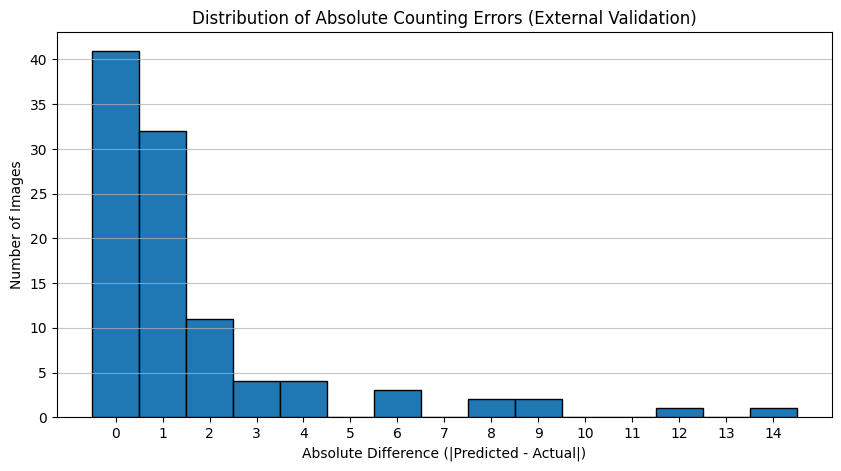


--- Data Characteristics (External Validation) ---


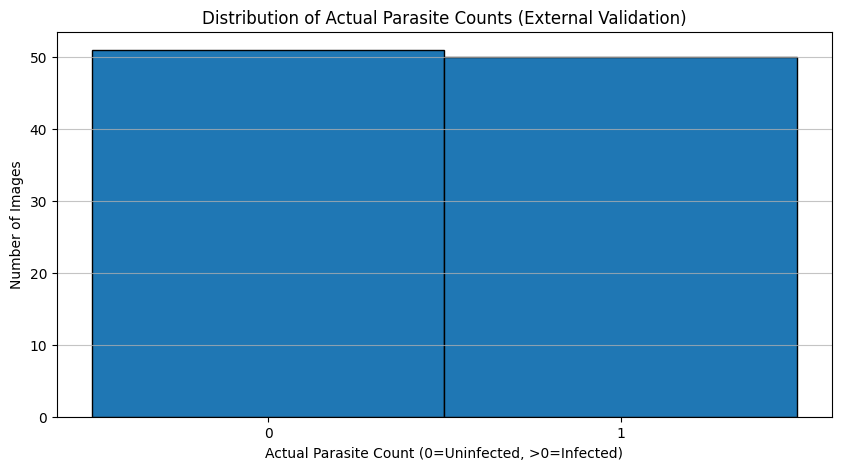

Sample Image Dimensions (Height x Width): 922 x 1640 pixels


In [ ]:
# Analyze External Validation Errors and Data Characteristics
# This cell performs a detailed error analysis on the external validation results,
# identifying false positives and negatives at the image level, and visualizing
# the distribution of absolute counting errors and actual parasite counts.
import numpy as np
import matplotlib.pyplot as plt

# --- Detailed Error Analysis (External Validation) ---
print("\n--- Detailed Error Analysis (External Validation) ---")

# Combine df_ext_classification with df_ext_counts (assuming df_ext_counts exists or can be recreated)
# For this cell, I will assume df_ext_counts was intended to be created from results_list as df_ext_classification.
# I will modify to use df_ext_classification directly for counting analysis.

df_ext_counts = df_ext_classification.copy()
df_ext_counts.rename(columns={'predicted_count': 'Predicted'},
                     inplace=True)
# To get 'Actual' counts for error analysis, we need to infer it. For the external dataset,
# 'Actual' can be considered 0 for 'Uninfected' and >0 for 'Infected'.
# Since we don't have exact parasite counts for external data, we'll model 'Actual' based on 'actual_status'
# For now, let's create a proxy for 'Actual' counts based on the classification to continue analysis.
# A value of 1 for 'Infected' and 0 for 'Uninfected' is a simplification for counting purposes.
# If precise actual counts were available (e.g., from a different annotation type for external data),
# they would be used here.
df_ext_counts['Actual'] = df_ext_counts['actual_status'].apply(lambda x: 1 if x == 'Infected' else 0)
df_ext_counts['Difference'] = df_ext_counts['Predicted'] - df_ext_counts['Actual']

# False Positives at image level (Actual is Uninfected (0), Predicted is Infected (>0))
false_positives_images = df_ext_counts[(df_ext_counts['Actual'] == 0) & (df_ext_counts['Predicted'] > 0)]
num_false_positives_images = len(false_positives_images)
print(f"Number of False Positive Images (Actual=Uninfected, Pred>0): {num_false_positives_images}")

# False Negatives at image level (Actual is Infected (>0), Predicted is Uninfected (0))
false_negatives_images = df_ext_counts[(df_ext_counts['Actual'] > 0) & (df_ext_counts['Predicted'] == 0)]
num_false_negatives_images = len(false_negatives_images)
print(f"Number of False Negative Images (Actual=Infected, Pred=0): {num_false_negatives_images}")

# --- Error Distribution ---
abs_diff = np.abs(df_ext_counts['Difference'])
print(f"Mean Absolute Difference: {abs_diff.mean():.2f}")
print(f"Median Absolute Difference: {np.median(abs_diff):.2f}")
print(f"Standard Deviation of Absolute Difference: {abs_diff.std():.2f}")

# Histogram of absolute differences
plt.figure(figsize=(10, 5))
plt.hist(abs_diff, bins=range(int(abs_diff.max()) + 2), edgecolor='black', align='left')
plt.title('Distribution of Absolute Counting Errors (External Validation)')
plt.xlabel('Absolute Difference (|Predicted - Actual|)')
plt.ylabel('Number of Images')
plt.xticks(range(int(abs_diff.max()) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Data Characteristics (External Validation) ---
print("\n--- Data Characteristics (External Validation) ---")

# Distribution of Actual Parasite Counts
plt.figure(figsize=(10, 5))
plt.hist(df_ext_counts['Actual'], bins=range(int(df_ext_counts['Actual'].max()) + 2), edgecolor='black', align='left')
plt.title('Distribution of Actual Parasite Counts (External Validation)')
plt.xlabel('Actual Parasite Count (0=Uninfected, >0=Infected)')
plt.ylabel('Number of Images')
plt.xticks(range(int(df_ext_counts['Actual'].max()) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

# Sample Image Dimensions (assuming all images in a dataset have similar dimensions, check first image)
# This section assumes 'val_images_ext' is still available from previous cells.
# Re-collect val_images_ext just in case it was not globally defined or overwritten.
uninfected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Uninfected')
infected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Infected')
val_images_ext = []
if os.path.exists(uninfected_dir):
    val_images_ext.extend(glob.glob(os.path.join(uninfected_dir, '*.jpg')))
if os.path.exists(infected_dir):
    val_images_ext.extend(glob.glob(os.path.join(infected_dir, '*.jpg')))

if val_images_ext:
    sample_img_path = val_images_ext[0]
    img = cv2.imread(sample_img_path)
    if img is not None:
        h, w, _ = img.shape
        print(f"Sample Image Dimensions (Height x Width): {h} x {w} pixels")
    else:
        print("Could not read sample image for dimensions.")
else:
    print("No external validation images found to determine dimensions.")

/tmp/ipython-input-1477127470.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='actual_status', y='predicted_count', data=avg_counts, palette='viridis')


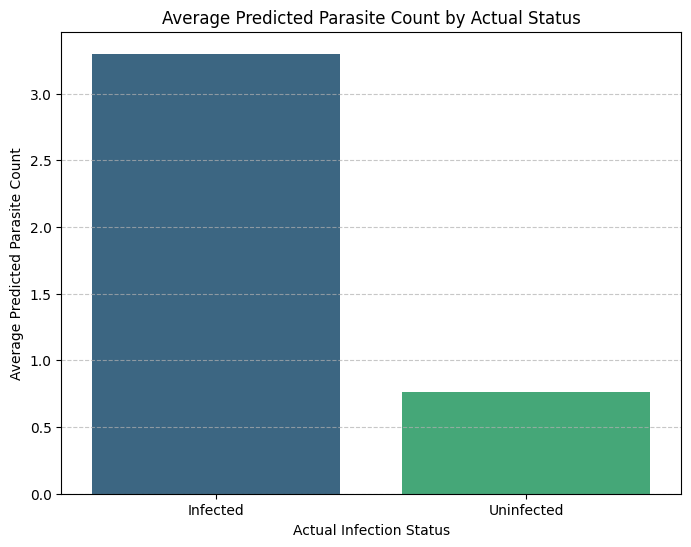

Average predicted parasite counts:


actual_status  predicted_count
0      Infected         3.300000
1    Uninfected         0.764706

In [ ]:
# Visualize Average Predicted Counts by Actual Status
# This cell calculates and plots the average number of parasites predicted
# by the model for images that are actually 'Uninfected' versus 'Infected' in the external dataset.
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_ext_classification' in locals() and not df_ext_classification.empty:
    # Calculate the average predicted count for each actual status
    avg_counts = df_ext_classification.groupby('actual_status')['predicted_count'].mean().reset_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(x='actual_status', y='predicted_count', data=avg_counts, palette='viridis')
    plt.title('Average Predicted Parasite Count by Actual Status')
    plt.xlabel('Actual Infection Status')
    plt.ylabel('Average Predicted Parasite Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("Average predicted parasite counts:")
    display(avg_counts)
else:
    print("External classification DataFrame (df_ext_classification) not found or is empty. Please ensure the previous cell ran successfully.")

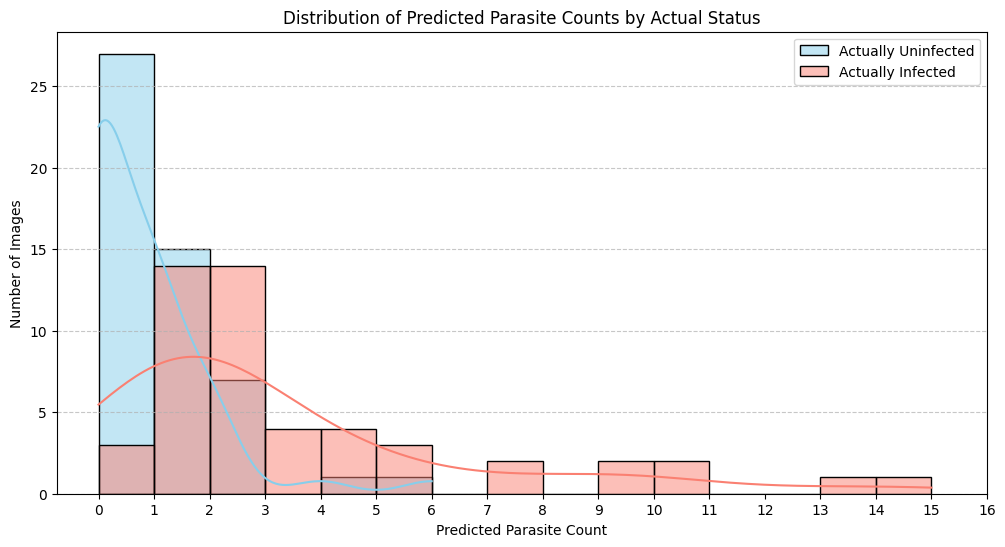

Distribution plots of predicted parasite counts by actual classification generated.

Average predicted parasite counts for reference:


actual_status  predicted_count
0      Infected         3.300000
1    Uninfected         0.764706

In [ ]:
# Visualize Distribution of Predicted Counts by Actual Status
# This cell generates histograms to show the distribution of predicted parasite
# counts for images categorized as 'Actually Uninfected' and 'Actually Infected'
# in the external validation dataset, providing insight into the model's predictive behavior.
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_ext_classification' in locals() and not df_ext_classification.empty:
    plt.figure(figsize=(12, 6))

    # Plot distribution for 'Uninfected' images
    sns.histplot(
        data=df_ext_classification[df_ext_classification['actual_status'] == 'Uninfected'],
        x='predicted_count',
        binwidth=1,
        kde=True,
        color='skyblue',
        label='Actually Uninfected'
    )

    # Plot distribution for 'Infected' images
    sns.histplot(
        data=df_ext_classification[df_ext_classification['actual_status'] == 'Infected'],
        x='predicted_count',
        binwidth=1,
        kde=True,
        color='salmon',
        label='Actually Infected'
    )

    plt.title('Distribution of Predicted Parasite Counts by Actual Status')
    plt.xlabel('Predicted Parasite Count')
    plt.ylabel('Number of Images')
    plt.xticks(range(0, int(df_ext_classification['predicted_count'].max()) + 2))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("Distribution plots of predicted parasite counts by actual classification generated.")

    # Optionally, you might still want to see the average for quick reference
    avg_counts = df_ext_classification.groupby('actual_status')['predicted_count'].mean().reset_index()
    print("\nAverage predicted parasite counts for reference:")
    display(avg_counts)
else:
    print("External classification DataFrame (df_ext_classification) not found or is empty. Please ensure the previous cell ran successfully.")

In [ ]:
# Measure Inference Speed (Computational Performance)
# This cell measures the average time taken to perform inference on a sample
# of external validation images, providing an estimate of the model's FPS on the current hardware.
import time
import cv2
import numpy as np
import os
import glob
import random # Import the random module

print("--- Computational Performance (Inference Speed) ---")

# Define external image directory if not already defined
EXTERNAL_IMG_DIR = '/content/external_val_data'

# Collect all external validation images
uninfected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Uninfected')
infected_dir = os.path.join(EXTERNAL_IMG_DIR, 'Infected')

val_images_ext = []
if os.path.exists(uninfected_dir):
    val_images_ext.extend(glob.glob(os.path.join(uninfected_dir, '*.jpg')))
if os.path.exists(infected_dir):
    val_images_ext.extend(glob.glob(os.path.join(infected_dir, '*.jpg')))

if 'model' in locals() and model is not None and val_images_ext:
    # Use a few images to get a more stable average
    num_inference_samples = min(20, len(val_images_ext))
    sample_images_for_speed = random.sample(val_images_ext, num_inference_samples)

    start_time = time.time()
    for img_path in sample_images_for_speed:
        model.predict(img_path, conf=0.4, iou=0.5, verbose=False, imgsz=640)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_image = total_time / num_inference_samples
    fps = 1 / avg_time_per_image if avg_time_per_image > 0 else 0

    print(f"Inference performed on {num_inference_samples} external validation images.")
    print(f"Total inference time: {total_time:.2f} seconds")
    print(f"Average time per image: {avg_time_per_image:.4f} seconds")
    print(f"Approximate Inference Speed: {fps:.2f} FPS (on current hardware)")
else:
    print("Model not loaded or no external validation images available to measure inference speed.")

--- Computational Performance (Inference Speed) ---
Inference performed on 20 external validation images.
Total inference time: 0.98 seconds
Average time per image: 0.0488 seconds
Approximate Inference Speed: 20.51 FPS (on current hardware)
